In [18]:
import os
import warnings
import importlib
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score, accuracy_score, \
    precision_score, recall_score
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import KFold, LeavePGroupsOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import matplotlib
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tabpfn import TabPFNClassifier
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
# import shap
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
%matplotlib inline
# matplotlib.use('TkAgg')
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler  # install via: pip install imbalanced-learn
from deepod.models.time_series import TimesNet

warnings.filterwarnings('ignore')
from scipy.stats import skew
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

seed = 69
torch.manual_seed(seed)
np.random.seed(seed)



timescale = '06h'

segment_length = 8


label = 'agitation-next'       # detection     prediction
kfold = True                   # kfold         lopo

results_dir = '/home/ali/PycharmProjects/tihm/results/06h-anomaly-sequential-kfold-ctx-sta-phy'

os.makedirs(results_dir, exist_ok=False)

True
NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [19]:
root = '/home/ali/PycharmProjects/tihm/dataset'

if timescale == '06h':
    dataset = pd.read_csv(os.path.join(root, 'data-06h.csv'))
elif timescale == '12h':
    dataset = pd.read_csv(os.path.join(root, 'data-12h.csv'))
elif timescale == '24h':
    dataset = pd.read_csv(os.path.join(root, 'data-24h.csv'))

display(dataset.shape)

(10790, 69)

In [20]:
# display(dataset)

print(dataset['agitation'].equals(dataset['agitation-next']))

print(np.sum(dataset['agitation']))
print(np.sum(dataset['agitation-next']))

print(np.where(dataset['agitation'] == 1))
print(np.where(dataset['agitation-next'] == 1))

print(np.sum(dataset['agitation'] == 0),
      np.sum(dataset['agitation'] == 1))

print(np.sum(dataset['agitation-next'] == 0),
      np.sum(dataset['agitation-next'] == 1))

print(np.sum(dataset['agitation-four'] == 0),
      np.sum(dataset['agitation-four'] == 1),
      np.sum(dataset['agitation-four'] == 2),
      np.sum(dataset['agitation-four'] == 3))


# display(dataset)
print(dataset.columns.values)

False
135.0
135.0
(array([  117,   358,   528,   532,   536,   537,   552,   564,   568,
         572,   597,   661,   669,   923,   935,   940,   944,   963,
         967,   983,  1039,  1044,  1055,  1074,  1662,  2660,  2986,
        3010,  3163,  4157,  4261,  4439,  4442,  4454,  4460,  4464,
        4467,  4468,  4470,  4471,  4472,  4474,  4476,  4480,  4482,
        4483,  4484,  4487,  4488,  4491,  4492,  4495,  4504,  4506,
        4507,  4515,  4519,  4520,  4530,  4532,  4555,  4571,  4579,
        4593,  4692,  4740,  4741,  4748,  4764,  4772,  4792,  4891,
        5066,  5067,  5195,  5386,  5503,  5504,  5523,  5543,  5564,
        5567,  5587,  5591,  5600,  5622,  5626,  5649,  5827,  5828,
        6034,  6120,  6152,  6156,  6164,  6185,  6204,  7192,  7197,
        7241,  7384,  7493,  7501,  7502,  7509,  7517,  7518,  7525,
        7533,  7534,  7537,  7541,  7568,  8661,  8976,  8977,  9070,
        9074,  9087,  9094,  9103,  9186,  9426,  9470,  9514,  9526,
 

In [21]:
# Agitation Statistics

temp = dataset.copy()

temp['agitation'].fillna(0, inplace=True)


print(f"Total number of participants: {temp['id'].nunique()}")
print(f"Total number of participants with at least one agitation episode: {temp[temp['agitation'] == 1]['id'].nunique()}")
print(f"Total number of participants with no agitation episodes: {temp['id'].nunique() - temp[temp['agitation'] == 1]['id'].nunique()}")
print(f"Total number of agitation episodes: {(temp['agitation'] == 1).sum()}")


ids, total_counts = np.unique(temp['id'], return_counts=True)
agitated_ids, agitation_counts = np.unique(temp[temp['agitation'] == 1]['id'], return_counts=True)
agitation_map = dict(zip(agitated_ids, agitation_counts))
unique_dates = temp.groupby('id')['date'].nunique().reindex(ids, fill_value=0).values
participant_summary_df = pd.DataFrame({
    'participant_id': ids,
    'six_hour_sample_count': total_counts,
    'unique_dates': unique_dates,
    'agitation_episodes': [agitation_map.get(pid, 0) for pid in ids]
})
participant_summary_df = participant_summary_df.sort_values(by='agitation_episodes', ascending=False).reset_index(drop=True)
# display(participant_summary_df)


# values, counts = np.unique(temp.loc[temp['agitation'] == 1, '6h'], return_counts=True)
# values, counts = np.unique(temp.loc[temp['agitation'] == 1, '12h'], return_counts=True)
# values, counts = np.unique(temp.loc[temp['agitation'] == 1], return_counts=True)

# agitation_temporal_df = pd.DataFrame({
#     '6h_time_block': values,
#     'agitation_episode_count': counts
# })
# display(agitation_temporal_df)

Total number of participants: 56
Total number of participants with at least one agitation episode: 27
Total number of participants with no agitation episodes: 29
Total number of agitation episodes: 135


In [22]:
# 03

if timescale == '06h':
    columns_indices = ['id', 'date', '6h']
elif timescale == '12h':
    columns_indices = ['id', 'date', '12h']
elif timescale == '24h':
    columns_indices = ['id', 'date']

# 08
columns_count = ['back-door', 'bathroom', 'bedroom', 'fridge-door',
                 'front-door', 'hallway', 'kitchen', 'lounge']

# 08
columns_contextual = ['total-events', 'unique-locations', 'active-location-ratio', 'private-to-public-ratio',
                      'location-entropy', 'location-dominance-ratio', 'back-and-forth-count', 'num-transitions']

# 32
columns_statistical = ['back-door-count-max', 'back-door-count-mean', 'back-door-count-std', 'back-door-count-sum',
                       'bathroom-count-max', 'bathroom-count-mean', 'bathroom-count-std', 'bathroom-count-sum',
                       'bedroom-count-max', 'bedroom-count-mean', 'bedroom-count-std', 'bedroom-count-sum',
                       'fridge-door-count-max', 'fridge-door-count-mean', 'fridge-door-count-std', 'fridge-door-count-sum',
                       'front-door-count-max', 'front-door-count-mean', 'front-door-count-std', 'front-door-count-sum',
                       'hallway-count-max', 'hallway-count-mean', 'hallway-count-std', 'hallway-count-sum',
                       'kitchen-count-max', 'kitchen-count-mean', 'kitchen-count-std','kitchen-count-sum',
                       'lounge-count-max', 'lounge-count-mean', 'lounge-count-std','lounge-count-sum']

# 08
columns_physiology = ['body-temperature', 'body-weight', 'diastolic-blood-pressure', 'heart-rate',
                      'muscle-mass', 'systolic-blood-pressure', 'total-body-water', 'skin-temperature']

# 06
columns_labels = ['blood-pressure', 'agitation', 'body-water', 'pulse', 'weight', 'body-temperature-label']

# 02
columns_demographics = ['age', 'sex']

# 02
columns_prediction = ['agitation-next', 'agitation-four']

print(len(columns_count),
      len(columns_statistical),
      len(columns_contextual),
      len(columns_physiology),
      len(columns_demographics),
      len(columns_labels))



8 32 8 8 2 6


In [23]:
columns = columns_indices + columns_count + columns_contextual + columns_statistical + columns_physiology + columns_labels + columns_demographics + columns_prediction
print(dataset.columns.to_list())
print(columns)

print(columns == dataset.columns.to_list())


# y = np.array(dataset[[label]]).squeeze()

# if label == 'agitation' or label == 'agitation-next':
#     y[y == -1] = 0
#     y[y >= 1] = 1
# elif label == 'agitation-four':
#     y[y == -1] = 0
#     y[y == -10] = 0

# ids = np.array(dataset['id']).squeeze()
# p = np.unique(ids, return_inverse=True)[1]

# print(np.isnan(y).sum())
# print(np.isnan(p).sum())

# y = np.nan_to_num(y, nan=0)

# print(np.isnan(y).sum())
# print(np.isnan(p).sum())

# print(np.unique(y))
# print(y.sum())


# To Drop
dataset.drop(
    
    columns_count +
    

    # columns_contextual +

    # columns_statistical +
    
    # columns_physiology +


    list(set(columns_labels) - set(['agitation'])) +

    columns_demographics +
    columns_prediction

    , axis=1, inplace=True)

print(dataset.columns.to_list())

# display('y: ', y)
# display('p: ', p)
display('dataset: ', dataset)


['id', 'date', '6h', 'back-door', 'bathroom', 'bedroom', 'fridge-door', 'front-door', 'hallway', 'kitchen', 'lounge', 'total-events', 'unique-locations', 'active-location-ratio', 'private-to-public-ratio', 'location-entropy', 'location-dominance-ratio', 'back-and-forth-count', 'num-transitions', 'back-door-count-max', 'back-door-count-mean', 'back-door-count-std', 'back-door-count-sum', 'bathroom-count-max', 'bathroom-count-mean', 'bathroom-count-std', 'bathroom-count-sum', 'bedroom-count-max', 'bedroom-count-mean', 'bedroom-count-std', 'bedroom-count-sum', 'fridge-door-count-max', 'fridge-door-count-mean', 'fridge-door-count-std', 'fridge-door-count-sum', 'front-door-count-max', 'front-door-count-mean', 'front-door-count-std', 'front-door-count-sum', 'hallway-count-max', 'hallway-count-mean', 'hallway-count-std', 'hallway-count-sum', 'kitchen-count-max', 'kitchen-count-mean', 'kitchen-count-std', 'kitchen-count-sum', 'lounge-count-max', 'lounge-count-mean', 'lounge-count-std', 'lounge

'dataset: '

,id,date,6h,total-events,unique-locations,active-location-ratio,private-to-public-ratio,location-entropy,location-dominance-ratio,back-and-forth-count,...,lounge-count-sum,body-temperature,body-weight,diastolic-blood-pressure,heart-rate,muscle-mass,systolic-blood-pressure,total-body-water,skin-temperature,agitation
0,0697d,2019-06-28,00-06,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0697d,2019-06-28,06-12,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0697d,2019-06-28,12-18,221.0,8.0,1.000,0.1691,2.7340,0.2579,35.0,...,49.0,36.1864,86.3,82.0,42.0,64.5,165.0,50.6,NaN,0.0
3,0697d,2019-06-28,18-24,101.0,7.0,0.875,0.0889,1.8916,0.4851,22.0,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0697d,2019-06-29,00-06,3.0,1.0,0.125,1.0000,-0.0000,1.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10785,fd100,2019-06-29,12-18,182.0,7.0,0.875,0.2283,2.5224,0.3077,31.0,...,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10786,fd100,2019-06-29,18-24,114.0,7.0,0.875,0.3671,2.4755,0.2982,19.0,...,34.0,36.2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10787,fd100,2019-06-30,00-06,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10788,fd100,2019-06-30,06-12,146.0,7.0,0.875,0.5465,2.5379,0.2603,10.0,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Imputation

import utils_data
importlib.reload(utils_data)
from utils_data import hierarchical_imputation, hierarchical_imputation_columns_to_exclude


print(dataset.isna().sum().sum())

dataset = hierarchical_imputation_columns_to_exclude(dataset, columns_to_exclude=columns_indices + ['agitation'])

print(dataset.isna().sum().sum())

temp = dataset.drop(columns_indices + ['agitation'], axis=1, inplace=False)
                    
print(temp.isna().sum().sum())


98769
8900
0


In [26]:
# Dataset - Sequential

import utils_data
importlib.reload(utils_data)
from utils_data import segment_dataframe

dataset.fillna(0, inplace=True)

sements, labels, participants = segment_dataframe(dataset, segment_length, columns_indices)

x = np.array(sements)
y = np.array(labels)
p = np.unique(participants, return_inverse=True)[1]

np.save(os.path.join('/home/ali/PycharmProjects/tihm/xyp', 'x.npy'), x)
np.save(os.path.join('/home/ali/PycharmProjects/tihm/xyp', 'y.npy'), y)
np.save(os.path.join('/home/ali/PycharmProjects/tihm/xyp', 'p.npy'), p)

print(np.unique(y))
print(np.sum(y))
print(x.shape)
print(y.shape)
print(p.shape)

[0 1]
135
(10342, 8, 48)
(10342,)
(10342,)


In [ ]:
# TimesNet



name = 'TimesNet'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    x_train = x_train[y_train == 0]
    y_train = y_train[y_train == 0]

    print(participant, x_train.shape, x_test.shape)

    num_samples, time_steps, num_features = x_train.shape
    x_train_flat = x_train.reshape(-1, num_features)
    x_test_flat = x_test.reshape(-1, num_features)

    scaler = StandardScaler()
    scaler.fit(x_train_flat)
    x_train_scaled = scaler.transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train_scaled)
    x_train_scaled = normalizer.transform(x_train_scaled)
    x_test_scaled = normalizer.transform(x_test_scaled)

    x_train = x_train_scaled.reshape(num_samples, time_steps, num_features)
    x_test = x_test_scaled.reshape(x_test.shape[0], time_steps, num_features)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # Undersample class 0
    # data_percent = 1
    # reduction_percent = 100 - data_percent
    # print("Original class distribution:", Counter(y_train))    
    # class_0_idx = np.where(y_train == 0)[0]
    # class_1_idx = np.where(y_train == 1)[0]
    # # How many class 0 samples to keep
    # n_keep = int(len(class_0_idx) * (1 - reduction_percent / 100.0))
    # sampled_0_idx = np.random.choice(class_0_idx, size=n_keep, replace=False)
    # # Combine sampled class 0 with all class 1
    # final_idx = np.concatenate([sampled_0_idx, class_1_idx])
    # x_train = x_train[final_idx]
    # y_train =  y_train[final_idx]
    # print("Resampled class distribution:", Counter(y_train))


    # TimesNet

    print(x_train.shape)

    model = TimesNet()
    model.fit(x_train, y=None)

    # model = TimesNet(random_state=seed, verbose=0)
    # model.fit(
    #     x_train.reshape(x_train.shape[0], -1),
    #     y=None)

    # y_probs = model.decision_function(
    #     x_train.reshape(x_train.shape[0], -1))




    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    # Y_PREDS = np.append(Y_PREDS, y_preds)


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
# Y_PREDS = Y_PREDS[indx]

PROBS = 1 / (1 + np.exp(-(Y_PROBS - np.mean(Y_PROBS)) / np.std(Y_PROBS)))
Y_PREDS = (PROBS >= .5).astype(int)

# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

1 8273 2069
1 (8165, 8, 48) (2069, 8, 48)
(8165, 8, 48)


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [64, 8, 100, 48]

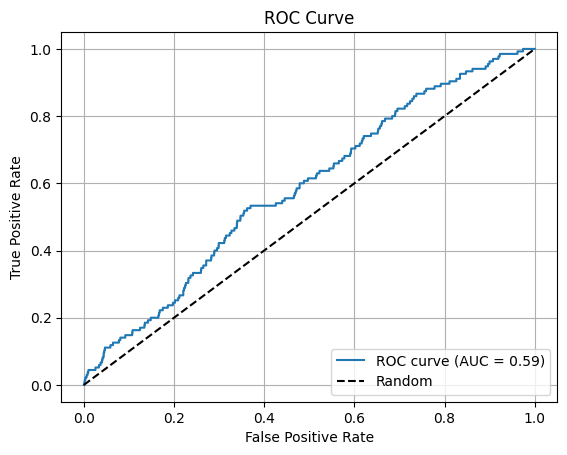

In [21]:

fpr, tpr, thresholds = roc_curve(Y_TRUES, Y_PROBS)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




